# Example : Obtaining accurate PES and ro-vibrational wavefunctions using experimental datasets on transition frequencies as reference


## Sample molecule N<sub>2</sub>

In [6]:
import sys
sys.path.insert(1, './../')

# import module here
from dep import diatomicSE
from dep import transition
from dep import PES_functions


# import python modules
import scipy.optimize as opt
import math
import numpy as np

###### for plotting #########################
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 2 ;
plt.rc('axes', linewidth=2) ;
plt.rcParams.update({'font.size': 18}) ;
plt.rcParams["font.family"] = "Arial";


In [2]:
from inspect import getmembers, isfunction
func_list= getmembers(PES_functions, isfunction)

for i in func_list:
    print(i)

('modification_morse_potential', <function modification_morse_potential at 0x148896ebcc80>)
('morse_potential', <function morse_potential at 0x148896ebcb70>)
('rydberg_potential_3param', <function rydberg_potential_3param at 0x148896ebcbf8>)


In [3]:
N2_ref = np.loadtxt('N2_ref_data/N2_ref_J4_v3.txt')
print(N2_ref.size)

33


### generating a PES function 

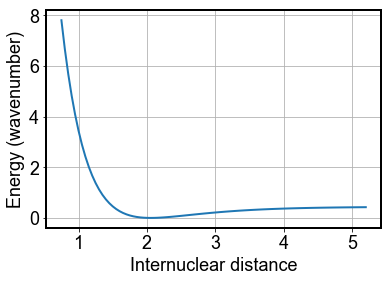

In [7]:
# N2 potential parameters
re=2.4102

param_opt=np.array([0.44, 1.265, 2.055])

distance_vector=np.arange(0.75, 5.25, 0.05)
test_PES = PES_functions.morse_potential(param_opt, distance_vector )


#plotting the test PES


plt.plot(distance_vector, test_PES )
plt.xlabel('Internuclear distance')
plt.ylabel('Energy (wavenumber)')
plt.grid()

---

### Getting rovibrational energies of N2

In [8]:
e = diatomicSE.get_eigenvalue_J( 7, 14, 7, 14, distance_vector , test_PES , 5, 0.025 , 0 )

In [9]:
print(e.shape)

(175, 1)


### This function calculates the diff

In [10]:

def residual_rovibration_3v (parameter):


    xfit = np.arange(0.75, 5.99 , 0.05)
    yfit = PES_functions.morse_potential(parameter,xfit)
    step = 0.010
    Jmax = 4


    e = diatomicSE.get_eigenvalue_J( 7, 14, 7, 14, xfit , yfit, 5, step , 0 )
    dat = np.zeros((e.shape[0], Jmax+1))
    dat[:, 0]=e[:,0]

    for i in range(1, Jmax+1):
        e = diatomicSE.get_eigenvalue_J( 7, 14, 7, 14, xfit , yfit, 5, step , i )

        dat[:, i]=e[:,0]


    S_v0v0= transition.S_branch(dat, 0, 0, Jmax)
    
    O_v0v1= transition.O_branch(dat, 0, 1, Jmax)
    Q_v0v1= transition.Q_branch(dat, 0, 1, Jmax)
    S_v0v1= transition.S_branch(dat, 0, 1, Jmax)
    
    O_v0v2= transition.O_branch(dat, 0, 2, Jmax)
    Q_v0v2= transition.Q_branch(dat, 0, 2, Jmax)
    S_v0v2= transition.S_branch(dat, 0, 2, Jmax)

    O_v0v3= transition.O_branch(dat, 0, 3, Jmax)
    Q_v0v3= transition.Q_branch(dat, 0, 3, Jmax)
    S_v0v3= transition.S_branch(dat, 0, 3, Jmax) 


    #print(S_v0v0.shape, O_v0v1.shape, Q_v0v1.shape, S_v0v1.shape )
    
    calc = np.hstack((S_v0v0,O_v0v1,Q_v0v1,S_v0v1,O_v0v2,Q_v0v2,S_v0v2,O_v0v3,Q_v0v3,S_v0v3))
    #print('calc shape  = ', calc.shape)

    # subtract with ref
    ref = N2_ref
    
    
    #print(calc)
    #print(ref)

    #print (calc.shape, ref.shape)
    #print(ref,'\n\n', calc)
    diff = calc - ref
    print(np.sum(diff**2))

    return np.sum(diff**2)


######################################################


In [11]:
# testing the function 
param_opt=np.array([0.44320, 1.2899, 2.07375])
residual_rovibration_3v (param_opt )


0.4912214647991154


0.4912214647991154

In [12]:
# This function is used to optimize the parameters of the PES analytical function


#######################################################
#   optimize function ( optimization of spline coefs)
def run_fit(initial_guess):


    res = opt.minimize( residual_rovibration_3v, initial_guess,\
                       method='Nelder-Mead', \
                              options={'xatol': 1e-8,\
                                       'fatol': 1e-8,\
                                           'maxiter':2500})

    #print (res)
    #opt_params = res.x

    return res
######################################################

In [13]:
# running optimization

result = run_fit( param_opt )

0.4912214647991154
473915.993253932
1772888.9017457843
78.15469645690388
805960.5015001169
108861.57663384643
821796.7465278483
84416.98876544948
262672.19764707086
13174.446296597722
136555.57611623994
16110.994093634405
41284.21214108771
2016.1871250490487
19170.674497606655
2443.6594280405243
5996.354877069999
310.01440394232884
3382.7187119907476
400.5313408920152
1032.2281733345503
66.0287263970505
426.0066424920414
75.27220729726324
13.237396944657021
144.89049757965662
13.53894931141636
116.56861014039048
12.295962935505425
27.695053919750794
2.2850821556646057
28.791257112264972
1.7173478718991624
20.76584701846119
2.4194667903558336
6.440255199167639
0.4135341472150836
2.9765592022480014
0.5925833399780444
3.5767903173516986
0.36012475598437405
0.20907641501635293
0.9368685356198458
1.0600181759118659
0.09286229250721961
1.3441671982355143
0.09358394604988343
0.07823905371286857
0.41475349216712154
0.35405307451121715
0.05233181796119101
0.042785681864960186
0.2628879277520242

In [14]:
# result of optimization procedue

print(result)

 final_simplex: (array([[0.44320254, 1.28993001, 2.07375154],
       [0.44320254, 1.28993   , 2.07375153],
       [0.44320254, 1.28993001, 2.07375153],
       [0.44320254, 1.28993   , 2.07375153]]), array([0.00052766, 0.00052766, 0.00052766, 0.00052766]))
           fun: 0.0005276640874987913
       message: 'Optimization terminated successfully.'
          nfev: 177
           nit: 89
        status: 0
       success: True
             x: array([0.44320254, 1.28993001, 2.07375154])


In [15]:
print(result.x)

[0.44320254 1.28993001 2.07375154]


In [16]:
# 
opt_PES =   PES_functions.morse_potential( result.x , distance_vector )

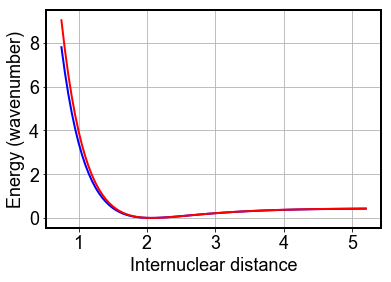

In [28]:
plt.plot(distance_vector, test_PES, 'b', distance_vector, opt_PES , 'r' )
plt.xlabel('Internuclear distance')
plt.ylabel('Energy (wavenumber)')

plt.grid()

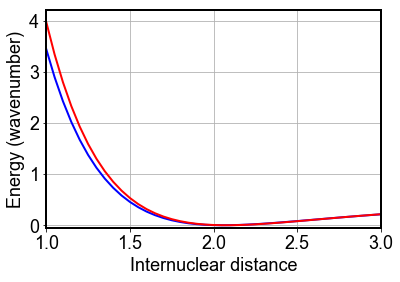

In [31]:
plt.plot(distance_vector, test_PES, 'b', distance_vector, opt_PES , 'r' )
plt.xlabel('Internuclear distance')
plt.ylabel('Energy (wavenumber)')
plt.xlim([1,3])
plt.ylim([-0.05 ,4.2])
plt.grid()

In [23]:
solution = diatomicSE.get_fullsolution_J( 7, 14, 7, 14, distance_vector , opt_PES , 5, 0.025 , 0 ) 
# solution is a tuple

In [24]:
print(len(solution))


print(solution[0].shape)
print(solution[0])
# this corresponds to the internuclear distance

3
(175,)
[0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075
 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375
 1.4   1.425 1.45  1.475 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675
 1.7   1.725 1.75  1.775 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975
 2.    2.025 2.05  2.075 2.1   2.125 2.15  2.175 2.2   2.225 2.25  2.275
 2.3   2.325 2.35  2.375 2.4   2.425 2.45  2.475 2.5   2.525 2.55  2.575
 2.6   2.625 2.65  2.675 2.7   2.725 2.75  2.775 2.8   2.825 2.85  2.875
 2.9   2.925 2.95  2.975 3.    3.025 3.05  3.075 3.1   3.125 3.15  3.175
 3.2   3.225 3.25  3.275 3.3   3.325 3.35  3.375 3.4   3.425 3.45  3.475
 3.5   3.525 3.55  3.575 3.6   3.625 3.65  3.675 3.7   3.725 3.75  3.775
 3.8   3.825 3.85  3.875 3.9   3.925 3.95  3.975 4.    4.025 4.05  4.075
 4.1   4.125 4.15  4.175 4.2   4.225 4.25  4.275 4.3   4.325 4.35  4.375
 4.4   4.425 4.45  4.475 4.5   4.525 4.55  4.575 4.6   4.625 4.65  4.675
 4.7   4.725 4.75  4.775 4.8   4.825 4.85 

In [25]:
print(solution[1].shape)
print(solution[1])
# this corresponds to the energies in Hartree

(175, 1)
[[1.22612337e+03]
 [3.55522273e+03]
 [5.85383038e+03]
 [8.12090375e+03]
 [1.03555673e+04]
 [1.25570915e+04]
 [1.47248770e+04]
 [1.68584387e+04]
 [1.89573494e+04]
 [2.10214115e+04]
 [2.30506207e+04]
 [2.50432931e+04]
 [2.70010688e+04]
 [2.89293821e+04]
 [3.08117999e+04]
 [3.26533054e+04]
 [3.44888537e+04]
 [3.62753017e+04]
 [3.80042976e+04]
 [3.97137896e+04]
 [4.13920165e+04]
 [4.30471172e+04]
 [4.46608325e+04]
 [4.62348898e+04]
 [4.77693783e+04]
 [4.92700961e+04]
 [5.07419232e+04]
 [5.21850803e+04]
 [5.35994005e+04]
 [5.49816875e+04]
 [5.63307943e+04]
 [5.76452584e+04]
 [5.89252219e+04]
 [6.01716178e+04]
 [6.13853236e+04]
 [6.25680399e+04]
 [6.37200399e+04]
 [6.48422012e+04]
 [6.59337625e+04]
 [6.69938901e+04]
 [6.80211378e+04]
 [6.90161079e+04]
 [6.99829176e+04]
 [7.09052403e+04]
 [7.17295013e+04]
 [7.25162485e+04]
 [7.34256028e+04]
 [7.43940452e+04]
 [7.46289794e+04]
 [7.54711829e+04]
 [7.65028898e+04]
 [7.75334500e+04]
 [7.85525799e+04]
 [7.88423375e+04]
 [7.95543525e+04]
 

In [26]:
print(solution[2].shape)
print(solution[2])
# this corresponds to the matrix of wavefunctions, where  each column corresponds to
# wavefunction for a vibrational state, starting from 0 to n across the columns, from left to right 
# These wavefunctions need normalization before using them for any further computation.

(175, 175)
[[-2.91257759e-046  2.91411588e-046 -7.70334179e-046 ... -6.50532898e-003
   1.48370646e-001 -9.90195150e-001]
 [ 2.50029422e-045  2.98696690e-045 -3.00069423e-044 ... -1.49310515e-001
   9.78944706e-001  1.38983531e-001]
 [ 3.36594613e-043 -2.64842748e-043  3.38530770e-043 ... -9.75453484e-001
  -1.39361092e-001 -1.39971461e-002]
 ...
 [ 2.01416369e-058  4.85180150e-057 -8.25590382e-056 ... -1.04330306e-242
  -4.17896499e-248 -3.18140498e-253]
 [-1.61760913e-058 -2.48931940e-057  5.25408298e-056 ...  3.81803712e-244
   1.44818169e-249  1.04783440e-254]
 [ 9.23797294e-059  1.00419289e-057 -2.59227691e-056 ... -1.39665112e-245
  -5.01674894e-251 -3.45011066e-256]]
